In [1]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift, fft, ifft
import soundfile as sf
from scipy.signal import hann
from CircularBuffer import CircularBuffer, StereoDelay

fs = 48000
#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

#Impulse Signal
#data = np.zeros(fs)
#data[0] = 1


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8


# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [2]:
delay_amts = [0.02, 0.03, 0.025]

dry_amt = 0.4

#Decay factor
gamma = 0.9

# b, c and k gains
b = [0.8, 0.9, 1]
c = [0.7, 0.8, 0.9]
k = [0.6, 0.7, 0.8]

# Feedback matrix
fdn_Matrix = [[-0.3, 0.5, -0.7], 
              [0.4, -0.1, 0.6], 
              [-0.2, 0.3, -0.5]]


delayLines = []
for i in range(len(delay_amts)):
    delayLines.append(StereoDelay(delay_amts[i] * fs, delay_amts[i] * fs))

output = np.zeros((len(data), 2))
for i in range(len(data)):
    wet_out = [0,0]
    for d in range(len(delayLines)):
        #Retrieve delayed samples
        temp = delayLines[d].get_samples_from_buffer()
        # k gain
        delayedL = temp[0] * k[d]
        delayedR = temp[1] * k[d]

        fdbkL = fdn_Matrix * np.array(delayedL)
        fdbkR = fdn_Matrix * np.array(delayedR)

        tempL = 0
        tempR = 0
        for t in range(len(delayLines)):
            tempL += fdbkL[d,t]
            tempR += fdbkR[d,t]
        
        lineFdbk = [tempL, tempR]

        delayLines[d].push_samples_to_buffer(lineFdbk + (b[d] * data[i]))

        wet_out += np.multiply(c[d], [delayedL, delayedR])   

    output[i] = (dry_amt * data[i]) + ((1-dry_amt) * wet_out)

#Normalisation
max_amplitude = np.max(np.abs(output))
normalized_audio = output / max_amplitude

In [3]:
sd.play(normalized_audio, fs)

# Impulse Response of system

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_58004/2450523449.py:2: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(len(data))


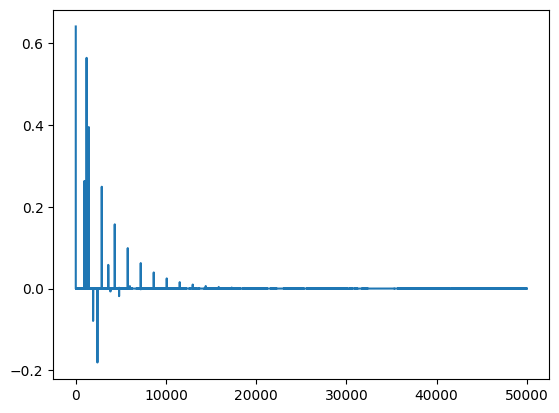

In [35]:
# Apply windowing
window = hann(len(data))
original_signal = data[:,0] * window
filtered_signal = normalized_audio[:,0] * window

original_spectrum = fft(original_signal)
filtered_spectrum = fft(filtered_signal)

epsilon = 1e-10

impulse_response_spectrum = filtered_spectrum/(original_spectrum + epsilon)

impulse_response = np.real(ifft(impulse_response_spectrum))

plt.plot(impulse_response[0:50000])

In [14]:
#Write to wav file
#sf.write('FDN.wav', normalized_audio, fs,)